# Demo of 'live' twitter sentiment analysis.

This is a work in progress project using tweepy and textblob to perform 'live' twitter sentiment analysis.

The word 'live' is in quotes because, while we are catching live tweets, analysing the sentiment and writing it into a csv file in real time, the plotting and visualisation are all done post-hoc from the datafile, so by the time you get to see the data, it's a little out of date.

## Import dependencies





*   tweepy - Interact with twitter API
*   textblob - Sentiment analysis
*   pandas - Create dataframe
*   matplotlib - Plotting
*   re - Regex for text cleaning
*   csv - read/write CSVs
*   nltk - Natural language toolkit

In [ ]:
import tweepy
from tweepy import Stream
from tweepy import StreamListener
from  textblob import TextBlob
import re
import csv
import nltk

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

Might need to install 'punkt'

In [ ]:
nltk.download('punkt')

## Set up Twitter API access

Insert your own Twitter API keys and tokens here ;)

In [ ]:
api_key = ""
api_key_secret = ""
api_token = ""
api_token_secret = ""

In [ ]:
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(api_token, api_token_secret)
api = tweepy.API(auth)

Run this just to check everything is working. If so, you can read your twitter feed here now! How (in)convenient!

In [ ]:
tweets = api.home_timeline()
for tweet in tweets:
  print(tweet.text)

## Function and class definitions

This part is still very messy and many functions should be extracted and modularised outside of the stream listener. It should be considered a proof of concept / work in progress for now.

Currently, we create a data file, create a stream listener and then inside that stream listener, we do some sentiment analysis using textblob and then add that sentiment (+1 is good, -1 is bad, 0 is neutral) to the running counts for each of the keywords we identified. and then write it into a file. 

- Note 1: we only count here if the tweet mentions only one of the agents, since then we don't get confused with things like "I hate coke but I love pepsi" accidentally counting negative for pepsi and positive for coke etc.
- Note 2: we can see that a LOT of data is actually available to us from the stream listener, here we are only using the text, but in general it might be useful to look at the user description, location etc. Even the background colour of their user profile! There are more things available as well, although I am not yet sure what the complete set of methods and variables is.

### Create stream listener and write into data file

In [ ]:
trump = 0
biden = 0

header_name = ['Trump', 'Biden']
with open('sentiment.csv', 'w') as file:
    writer = csv.DictWriter(file, fieldnames=header_name)
    writer.writeheader()

class StreamListener(tweepy.StreamListener):
    def on_status(self, status):

      description = status.user.description
      loc = status.user.location
      text = status.text
      coords = status.coordinates
      name = status.user.screen_name
      user_created = status.user.created_at
      followers = status.user.followers_count
      id_str = status.id_str
      created = status.created_at
      retweets = status.retweet_count
      bg_color = status.user.profile_background_color
      
      blob = TextBlob(text)
      sent = blob.sentiment
      polarity = sent.polarity
      subjectivity = sent.subjectivity

      
      text = re.sub(r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)', r' ', text)
      text = re.sub(r'RT',' ', text)
      blob = TextBlob(text)
      
      global trump
      global biden
            
      trump_sentiment = 0
      biden_sentiment = 0
            
      for sent in blob.sentences:
        if "Trump" in sent and "Biden" not in sent:
          trump_sentiment = trump_sentiment + sent.sentiment.polarity # could also use sentiment.subjectivity
        if "Biden" in sent and "Trump" not in sent:
          biden_sentiment = biden_sentiment + sent.sentiment.polarity # could also use sentiment.subjectivity
            
      trump = trump + trump_sentiment
      biden = biden + biden_sentiment
            
      with open('sentiment.csv', 'a') as file:
        writer = csv.DictWriter(file, fieldnames=header_name)
        info = {
            'Trump': trump,
            'Biden': biden
            }
        writer.writerow(info)

      # uncomment these lines if you want to flood the console with garbage/tweets.      
      #print(text)
      #print()

    def on_error(self, status_code):
      if status_code == 420:
        return False

### Run stream listener

Run the stream listener for as long as you like and gather data!

N.B. you will need to manually interrupt this cell when you are finished.

In [ ]:
stream_listener = StreamListener()
stream = tweepy.Stream(auth=auth, listener=stream_listener)
stream.filter(track=["trump", "biden", "joe biden", "donald trump"])

## Plot data

Read the data in from a CSV file we created earlier.

In [ ]:
df = pd.read_csv('/content/sentiment.csv')

Plot a graph.

Many of these plotting options are quite idiosyncratic to my own personal tastes. Feel free to modify/tinker with it and remove the watermark :P

Text(0.99, 0.025, '(c) E. Maitland 2020')

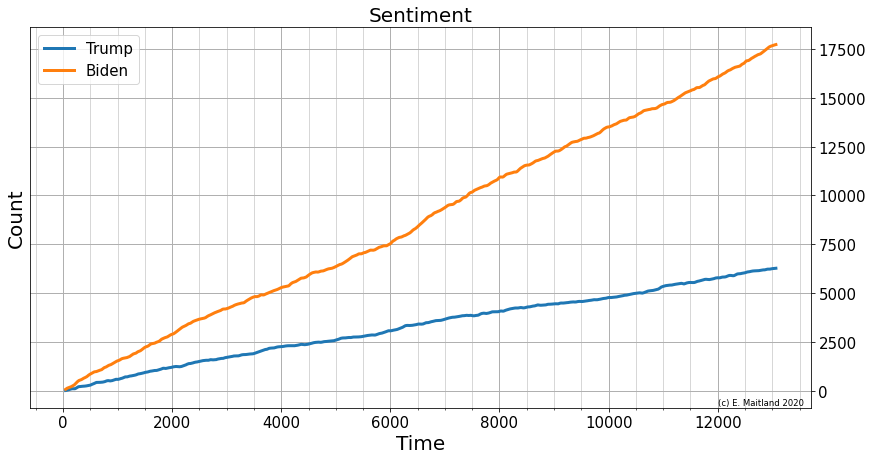

In [ ]:
MARKERS = 'ov^.psDPx*<>+pDov^.ps'

#choose if you want a smoothed plot or not
#recommend to only use this if you are gathering 1000+ tweets
smoothed = True

fig = plt.figure(figsize = (14,7))
ax = fig.add_subplot(111)

if smoothed:
    ax.plot(df.index.to_numpy(),((df.fillna(value=0)).rolling(50).sum()/2).to_numpy(),markevery=20,linewidth=3,markersize=0)
    ax.set_title('Sentiment of tweets (+ve/-ve)',fontsize=20)
else:
    ax.plot(df.index.to_numpy(),(df.fillna(value=0)).to_numpy(),markevery=20,linewidth=2,markersize=10)
    ax.set_title('Sentiment of tweets (+ve/-ve)',fontsize=20)
ax.grid(axis='y', which='major', linewidth=1)
ax.grid(axis='y', which='minor', linewidth=0.5)
ax.grid(axis='x', which='major', linewidth=1)
ax.grid(axis='x', which='minor', linewidth=0.5)
for i, line in enumerate(ax.get_lines()):
    line.set_marker(MARKERS[i])
ax.set_xlabel('Tweets',fontsize=20)
ax.set_ylabel('Sentiment',fontsize=20)
ax.legend(ax.get_lines(), df.columns,fontsize=15, loc='upper left')
ax.yaxis.tick_right()
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
if logscale:
    ax.set_yscale('log')
    locmin = plticker.LogLocator(base=10.0, subs=(1,10 ))
    ax.yaxis.set_major_formatter(plticker.FormatStrFormatter("%.0f"))
    ax.yaxis.set_major_locator(locmin)
#ax.xaxis.set_major_locator(plticker.AutoLocator())
ax.xaxis.set_minor_locator(plticker.AutoMinorLocator())
ax.text(0.99, 0.025, "(c) E. Maitland 2020", transform=ax.transAxes, fontsize=8.5, va='top', ha='right')

In [ ]:
a = 0
b = 0

if a and not b:
  print("yes")
if b and not a:
  print("no")